# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [41]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


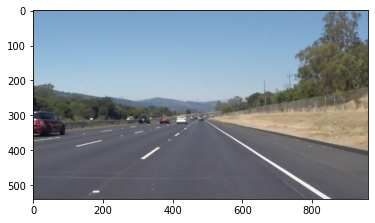

In [43]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [45]:
import math
from statistics import stdev

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_best_fitting_lines(left_lines, right_lines):

    # Both lane lines should have similar slope except one is pos, one neg.
    # Combine both and compute the average and remove all slopes that are not
    # within +/- 50% of average to remove outliers and artifacts
    all_slopes_abs = [abs(line[0]) for line in left_lines + right_lines]
    # print("all slopes sorted", all_slopes)
    ave_slope = sum(all_slopes_abs) / len(all_slopes_abs)
    # calc range for slope
    slope_range = ave_slope * .5
    # keep lines that have slope within range, outliers removed
    left_lines = [line for line in left_lines if 
                line[0] > -ave_slope - slope_range and
                line[0] < -ave_slope + slope_range ]
    right_lines = [line for line in right_lines if 
                line[0] > ave_slope - slope_range and
                line[0] < ave_slope + slope_range]

    # recalc ave slope with outliers removed - should be closer to true slope 
    ave_slope = sum([abs(line[0]) for line in left_lines + right_lines]) / len(all_slopes_abs)

    if len(left_lines) >= 2:
        # need at least 2 points to calc std
        left_line_std = stdev([line[0] for line in left_lines])
    else:
        # use 5% of ave slope for std if less than 2 lines
        left_line_std = ave_slope * .05 

    # as long as there are more than 3 lines on lane, make 
    # 2 passes to remove outlier
    # first pass removes 1 std away, 2nd pass removes 2 std away. 
    loop_count = 1
    while len(left_lines) > 3 and loop_count <= 2:
        # print("left line loop count, combined ave, left ave, std, per range ", 
        #     loop_count, ave_slope, left_line_std, percent_range)
        # print("count of left lines and slope", len(left_lines), sum([line[0] for line in left_lines])/len(left_lines))
        # print("loop count, ave slope, std, target std ", 
        #     loop_count, ave_slope, std, target_std)
        # store copy of left lines' values in case filter removes too many lines
        copy_left_lines = left_lines[:]
        # left line has negative slope so negate ave_slope 
        left_lines = [line for line in left_lines if 
                    line[0] > -ave_slope - left_line_std * loop_count and 
                    line[0] < -ave_slope + left_line_std * loop_count]
        # replace lines with copy if too many removed in filtering step above
        if len(left_lines) < 3:
            left_lines = copy_left_lines
        left_line_std = stdev([line[0] for line in left_lines])
        loop_count += 1

    if len(right_lines) >= 2:
        # need at least 2 points to calc std
        right_line_std = stdev([line[0] for line in right_lines])
    else:
        # use 5% of ave slope for std if less than 2 lines        
        right_line_std = ave_slope * .05 
    loop_count = 1
    while len(right_lines) > 3 and loop_count <= 2:
        # print("right line loop count, combined ave, right ave, std, perc range ", 
        #     loop_count, ave_slope, right_line_std, percent_range)
        # print("count of right lines and slope", len(right_lines), sum([line[0] for line in right_lines])/len(right_lines))
        copy_right_lines = right_lines[:]
        # right line has negative slope so negate ave_slope 
        right_lines = [line for line in right_lines if 
                        line[0] > ave_slope - right_line_std * loop_count and 
                        line[0] < ave_slope + right_line_std * loop_count]
        # replace lines if too many removed in filtering step above
        if len(right_lines) < 3:
            right_lines = copy_right_lines
        right_line_std = stdev([line[0] for line in right_lines])
        loop_count += 1

    left_line = None
    right_line = None
    n_left = len(left_lines)
    n_right = len(right_lines)

    def line_length(line):
        slope, x1, y1, x2, y2 = line 
        return math.sqrt((x2-x1)**2 + (y2-y1)**2)           
    # variable to hold the y value for lane line at highest detected point
    tip_y = float('inf')
    # used to multiply x to only keep lines within ave_slope * x_mult_factor
    x_mult_factor = 1.6
    if n_left > 0:
        # # calc average slope, x1, y1, x2, y2 left line
        ave_slope = sum([m for m,x1,y1,x2,y2 in left_lines]) / n_left      
        ave_x1 = sum([x1 for m,x1,y1,x2,y2 in left_lines]) / n_left      
        ave_y1 = sum([y1 for m,x1,y1,x2,y2 in left_lines]) / n_left      
        ave_x2 = sum([x2 for m,x1,y1,x2,y2 in left_lines]) / n_left               
        ave_y2 = sum([y2 for m,x1,y1,x2,y2 in left_lines]) / n_left 
        # left_line = (ave_slope, int(ave_x1), int(ave_y1), int(ave_x2), 
        #             int(ave_y2)) 

        longest = None
        for i in range(1, len(left_lines)):
            _, x1, y1, x2, y2 = left_lines[i]
            if longest is None and (x2 <= ave_x2 * x_mult_factor) and (x2 <= ave_x2 * x_mult_factor):
                longest = left_lines[i]
            else:
                # only do comparison if longest has been assigned a line
                if longest is not None:    
                    # set current line to longest if longer than current
                    if line_length(left_lines[i]) > line_length(longest):
                        # only lines most 20% away from x1, x2 mean 
                        if ( (x2 <= ave_x2 * x_mult_factor) and 
                            (x2 <= ave_x2 * x_mult_factor) ):
                            longest = left_lines[i]
            # set tip of lane line to highest point on image (closer to 0)
            y = min(y1, y2)
            if y < tip_y:
                tip_y = y
        #m, x1, y1, x2, y2 = longest            
        # use average slope to try to get smoother frames
        if longest is None:
            # sort and use middle line if no longest line found from last step
            left_line = sorted(left_lines, key = 
                lambda ln: ln[0])[len(left_lines)//2]     
        else:
            left_line = longest #m, x1, y1, x2, y2

    if n_right > 0:
        # # calc average slope, x1, y1, x2, y2 right line
        ave_slope = sum([m for m,x1,y1,x2,y2 in right_lines]) / n_right      
        ave_x1 = sum([x1 for m,x1,y1,x2,y2 in right_lines]) / n_right      
        ave_y1 = sum([y1 for m,x1,y1,x2,y2 in right_lines]) / n_right      
        ave_x2 = sum([x2 for m,x1,y1,x2,y2 in right_lines]) / n_right             
        ave_y2 = sum([y2 for m,x1,y1,x2,y2 in right_lines]) / n_right 
        # right_line = (ave_slope, int(ave_x1), int(ave_y1), int(ave_x2), 
        #             int(ave_y2)) 

        longest = None
        for i in range(1, len(right_lines)):
            _, x1, y1, x2, y2 = right_lines[i] 
            if longest is None and (x2 <= ave_x2 * x_mult_factor) and (x2 <= ave_x2 * x_mult_factor):
                longest = right_lines[i]
            else:
                # only do comparison if longest has been assigned a line
                if longest is not None:    
                    # set current line to longest if longer than current
                    if line_length(right_lines[i]) > line_length(longest):
                        # only lines most 20% away from x1, x2 mean 
                        if ( (x2 <= ave_x2 * x_mult_factor) and 
                        (x2 <= ave_x2 * x_mult_factor) ):
                            longest = right_lines[i]
            # set tip of lane line to highest point on image (closer to 0)
            y = min(y1, y2)
            if y < tip_y:
                tip_y = y
        #m, x1, y1, x2, y2 = longest
        # use average slope to try to get smoother frames but didn't work out
        if longest is None:
            # sort and use middle line
            right_line = sorted(right_lines, key = 
            lambda ln: ln[0])[len(right_lines)//2]    
        else:
            right_line = longest #m, x1, y1, x2, y2
    return (left_line, right_line, tip_y)


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    if len(img.shape) > 2:
        h, w, _ = img.shape
    else:
        h, w = img.shape
    # y value at tip of lane (same for both)
    tip_lane = int(h * .61)
    # y value at base of lane (same for both)
    base_lane = h
    center = w / 2
    left_lines = []
    right_lines = []

    # categorize lane line into left or right based on slope and position
    for line in lines:
        for x1,y1,x2,y2 in line:
            # add to left_lines if negative slope and x value is left of center 
            if x2-x1 == 0:
                continue
            slope = (y2-y1)/(x2-x1) 
            if  slope < 0 and (x1 < center or x2 < center):
                # cv2.line(img, (x1, y1), (x2, y2), red, thickness)
                left_lines.append((slope, x1, y1, x2, y2))
                # print("left slope ", slope)
            # add to left_lines if negative slope and x value is right of center 
            if  slope > 0 and (x1 > center or x2 > center):
                # cv2.line(img, (x1, y1), (x2, y2), blue, thickness)
                right_lines.append((slope, x1, y1, x2, y2))
                # print("right slope ", slope)                
    
    if left_lines and right_lines:
        left_line, right_line, tip_lane = calc_best_fitting_lines(left_lines, right_lines)
        
        if left_line is not None:
            # draw left line
            m, x1, y1, x2, y2 = left_line
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            # m = -slope
            b = y1 - m * x1
            # extend left line to tip of lane if needed
            if y1 > tip_lane:
                y0 = tip_lane
                x0 = int((y0 - b) / m)
                cv2.line(img, (x0, y0), (x1, y1), color, thickness)
            # extend left line to base of lane if needed
            if y2 < base_lane:
                y3 = base_lane
                x3 = int((y3 - b) / m)
                cv2.line(img, (x2, y2), (x3, y3), color, thickness)

        if right_line is not None:        
            # draw right line
            m, x1, y1, x2, y2 = right_line
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        # apply blur

            b = y1 - m * x1
            # extend right line to tip of lane if needed
            if y1 > tip_lane:
                y0 = tip_lane
                x0 = int((y0 - b) / m)
                cv2.line(img, (x0, y0), (x1, y1), color, thickness)
            # extend right line to base of lane if needed
            if y2 < base_lane:
                y3 = base_lane
                x3 = int((y3 - b) / m)
                cv2.line(img, (x2, y2), (x3, y3), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [47]:
# my CONSTANTS and helper functions


def default_roi_vertices(img):
    # given image and height and width of image, returns tuple of 4 point vertices
    # of (x, y) points (top-left, top-right, bottom-right, bottom-left)
    if len(img.shape) > 2:
        height, width, _ = img.shape 
    else:
        height, width = img.shape

    lane_center = width // 2
    horizon = height // 2
    y_top = horizon + 55 #50 #70
    y_bottom = height
    offset = int(width * .05) # orig 10% of width, change to 5%
    x_left_top = lane_center - offset*2.5   
    x_right_top = lane_center + offset*2.5
    x_left_bottom = 0 + offset 
    x_right_bottom = width - offset 
    vertices = ((x_left_top, y_top), (x_right_top, y_top), 
            (x_right_bottom, y_bottom), (x_left_bottom, y_bottom))
    return np.array([vertices], dtype=np.int32)

def remove_horizontal_lines(gray_image):

    imshape = gray_image.shape

    thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    np_gray_image = np.array(gray_image)
    normalized_np_gray_image = np_gray_image / 255
#     cv2.normalize(gray_image,  normalized_np_gray_image, 0, 255, cv2.NORM_MINMAX)
    
    # remove horizontal lines
    linek = np.zeros((11,11),dtype=np.uint8)
    linek[5,...]=1
    linek[...,5]=1
    x=cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, linek ,iterations=1)
    gray_image-=x
    return gray_image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # convert image to grayscale if not already
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        # Calculate the derivative (the 1, 0 at the end denotes xx direction):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        # Calculate the derivative (the 0, 1 at the end denotes yy direction):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)] = 1
    return binary_output
    

def white_and_yellow_mask(img):
    # must pass in cv2 hsv image
    # creates a mask to detect yellow and white lanes and returns image
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # good for 1st solidWhiteRight
    # (hMin = 0 , sMin = 0, vMin = 157), (hMax = 179 , sMax = 25, vMax = 255)

    # good for 1st solidYellowCurve
    # (hMin = 95 , sMin = 10, vMin = 129), (hMax = 179 , sMax = 155, vMax = 255)
    white_lower = np.array([0, 0, 157])
    white_upper = np.array([179, 25, 255])
    white_mask = cv2.inRange(hsv, white_lower, white_upper)

    yellow_lower = np.array([95, 10, 129])
    yellow_upper = np.array([179, 155, 255])
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

    # Calculate combined mask, and masked image
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked = cv2.bitwise_and(img, img, mask = mask)



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [49]:
import os
directory = "test_images/"
files = os.listdir(directory)

for file_name in files[3:4]:
    # print(file_name)
    img_path = directory + file_name
    image = mpimg.imread(img_path)
    img = np.copy(image)


In [51]:
# code to test effect of hsv tweaks on image to determine min and max 
# values of hsv image for masking yellow/white lane lines
# from https://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv#comment34389698_22588395

# import cv2
# import sys
# import numpy as np

# def nothing(x):
#     pass

# # Load in image - use preloaded test image above
# # image = cv2.imread('1.jpg')
# image = mpimg.imread('test_images/solidYellowCurve.jpg')

# # Create a window
# cv2.namedWindow('image')

# # create trackbars for color change
# cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
# cv2.createTrackbar('SMin','image',0,255,nothing)
# cv2.createTrackbar('VMin','image',0,255,nothing)
# cv2.createTrackbar('HMax','image',0,179,nothing)
# cv2.createTrackbar('SMax','image',0,255,nothing)
# cv2.createTrackbar('VMax','image',0,255,nothing)

# # Set default value for MAX HSV trackbars.
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize to check if HSV min/max value changes
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# output = image
# wait_time = 33

# while(1):

#     # get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin','image')
#     sMin = cv2.getTrackbarPos('SMin','image')
#     vMin = cv2.getTrackbarPos('VMin','image')

#     hMax = cv2.getTrackbarPos('HMax','image')
#     sMax = cv2.getTrackbarPos('SMax','image')
#     vMax = cv2.getTrackbarPos('VMax','image')

#     # Set minimum and max HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Create HSV Image and threshold into a range.
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     output = cv2.bitwise_and(image,image, mask= mask)

#     # Print if there is a change in HSV value
#     if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display output image
#     cv2.imshow('image',output)

#     # Wait longer to prevent freeze for videos.
#     if cv2.waitKey(wait_time) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()
# good for 1st solidWhiteRight
# (hMin = 0 , sMin = 0, vMin = 157), (hMax = 179 , sMax = 25, vMax = 255)

# good for 1st solidYellowCurve
# (hMin = 95 , sMin = 10, vMin = 129), (hMax = 179 , sMax = 155, vMax = 255)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

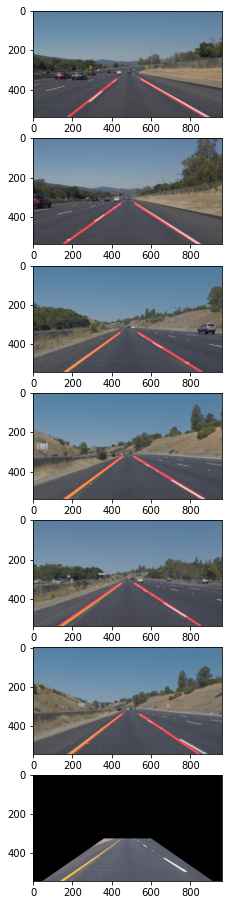

In [64]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def pipeline(img, roi_vertices=None):
    # assume img is read image file and not path

    save_directory = "test_images_output"
    if not os.path.isdir( save_directory ) :
        os.mkdir( save_directory )  # make sure the directory exists

    # convert to gray scale
    gray = grayscale(img)
    # save gray_scale for writeup
    cv2.imwrite(os.path.join(save_directory, "grayscale.jpg"), gray)

    masked_hor_removed = remove_horizontal_lines(gray)
    cv2.imwrite(os.path.join(save_directory, "remove_horizontal_lines.jpg"),        
                masked_hor_removed)
    # # apply blur
    # kernel = 16
    # blur_gray = gaussian_blur(img, kernel)
    # apply blur
    kernel = 9
    blurred = cv2.medianBlur(masked_hor_removed, kernel)
    cv2.imwrite(os.path.join(save_directory, "blurred.jpg"), blurred)    
    # masked_img = white_and_yellow_mask(blurred)

    # use canny to get edges in region of interest
    lo_thresh = 80
    hi_thresh = 200
    edges = canny(blurred, lo_thresh, hi_thresh)
    cv2.imwrite(os.path.join(save_directory, "canny_edges.jpg"), edges)    
    # define vertices for region of interest (can handle gray or color)
    if roi_vertices is None:
        roi_vertices = default_roi_vertices(blurred)

    # select region of interest (can handle gray or color)
    roi = region_of_interest(edges, roi_vertices)
    cv2.imwrite(os.path.join(save_directory, "region_of_interest.jpg"), roi)

    # # filter out horizontal lines
    # filtered = abs_sobel_thresh(roi, orient='x', thresh_min=20, thresh_max=100)

    # apply houghline tranform to edge image in region of interest
    lines = hough_lines(roi, rho=1, theta=np.pi/180, threshold=1, min_line_len=5, max_line_gap=2)
    cv2.imwrite(os.path.join(save_directory, "hough_lines.jpg"), lines)    
    #
    lines_on_image =  weighted_img(lines, img) 
    cv2.imwrite(os.path.join(save_directory, "pipeline_result.jpg"), lines_on_image)    
    return lines_on_image

# result = pipeline(image)

# plt.imshow(result)
images = []
for file_name in files:
    # print(file_name)
    img_path = directory + file_name
    image = mpimg.imread(img_path)
    images.append((file_name, image))

w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = 7
for i, (file_name, img) in enumerate(images):
    fig.add_subplot(rows, columns, i+1)
    result = pipeline(img)
    plt.imshow(result)
    save_directory = "test_images_output"
    if not os.path.isdir( save_directory ) :
        os.mkdir( save_directory )  # make sure the directory exists
    cv2.imwrite(os.path.join(save_directory, file_name), result)

# define vertices for region of interest (can handle gray or color)
vertices = default_roi_vertices(images[0][1])
# select region of interest (can handle gray or color)
roi = region_of_interest(images[4][1], vertices)
fig.add_subplot(rows, columns, 7)
plt.imshow(roi)

plt.show()

image0 = pipeline(images[0][1])
image1 = pipeline(images[1][1])
image2 = pipeline(images[2][1])
image3 = pipeline(images[3][1])
image4 = pipeline(images[4][1])
image5 = pipeline(images[5][1])



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [53]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [54]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [55]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 2/221 [00:00<00:12, 17.24it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 15.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [57]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 2/681 [00:00<00:40, 16.67it/s, now=None]Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 46 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [59]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|          | 2/251 [00:00<00:14, 16.67it/s, now=None]Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 34.4 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))